## Importar Librerías Estándares

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import gc

## Declarar Funciones

In [2]:
def get_rcc():
    rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
    rcc_test = pd.read_csv(f'{path}/rcc_test.csv')
    ##### inputar datos faltantes en la base de rcc_test
    rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
    rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

    dict_ = {'codmes': 'int32',
     'key_value': 'int32',
     'condicion': 'int32',
     'tipo_credito': 'int32',
     'cod_instit_financiera': 'int32',
     'PRODUCTO': 'int32',
     'RIESGO_DIRECTO': 'int32',
     'COD_CLASIFICACION_DEUDOR': 'int32'}
    rcc_train = rcc_train.astype(dict_)
    rcc_test = rcc_test.astype(dict_)
    return rcc_train, rcc_test

In [3]:
def get_rcc_list(df, desde, n):
    rcc_list=[]
    for feature in ['cod_instit_financiera','PRODUCTO']:
        rcc_list.append(get_unstack(df, feature, desde, n, 'Sum'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Unique'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Min'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Max'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Std'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Mean'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Median'))
    return rcc_list

In [4]:
def calculate_mode(x):
    try:
        moda=stat.mode(x)
    except:
        moda=np.nan
    return moda

In [5]:
def get_unstack(df, feature, desde, n, func):
    print(f'haciendo unstack de {feature} desde {desde} con la funcion de agregacion {func}')
    if func =='Sum':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.sum().unstack(level = 1, fill_value=np.nan)
    if func == 'Unique':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.size().unstack(level = 1, fill_value=np.nan)
    if func == 'Min':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.min().unstack(level = 1, fill_value=np.nan)
    if func == 'Max':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.max().unstack(level = 1, fill_value=np.nan)
    if func == 'Std':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.std().unstack(level = 1, fill_value=np.nan)
    if func == 'Mean':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.mean().unstack(level = 1, fill_value=np.nan)
    if func == 'Median':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.median().unstack(level = 1, fill_value=np.nan)
    df_result.columns = [f'{df_result.columns.name}_{value}_saldo{func}_ult{n+1}meses' for value in df_result.columns]
    gc.collect()      
    return df_result

In [6]:
def get_keep_columns(train, test):
    print(train.shape, test.shape)
    keep_columns = list(set(train.columns).intersection(test.columns))
    train = train[keep_columns]
    test = test[keep_columns]
    print(train.shape, test.shape)
    return  train, test

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

def cross_validation_lightgbm(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                       colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=50)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))])) 
    return test_probs, fi

In [8]:
def get_feature_selection(fi):
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

In [9]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
    return one_hot

In [10]:
def get_crosstab(df, index, feature):
    df = pd.crosstab(df[index], df[feature])
    df.columns = [f'{df.columns.name}_{i}' for i in df.columns]
    return df

## Cargar la variable Target

In [11]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

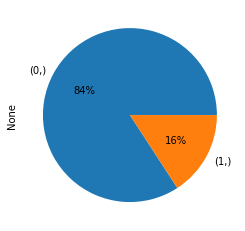

In [12]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Procesar RCC

In [11]:
rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
rcc_test = pd.read_csv(f'{path}/rcc_test.csv')

In [12]:
##### inputar datos faltantes en la base de rcc_test
rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

In [13]:
dict_ = {'codmes': 'int32',
 'key_value': 'int32',
 'condicion': 'int32',
 'tipo_credito': 'int32',
 'cod_instit_financiera': 'int32',
 'PRODUCTO': 'int32',
 'RIESGO_DIRECTO': 'int32',
 'COD_CLASIFICACION_DEUDOR': 'int32'}
rcc_train = rcc_train.astype(dict_)
rcc_test = rcc_test.astype(dict_)

In [14]:
##### categorizar la variable condicion
bins = [-1, 0, 10, 20, 30, 60, 90, 180, 360, 720, float("inf")]
rcc_train["condicion"] = pd.cut(rcc_train.condicion, bins)
rcc_train["condicion"] = rcc_train["condicion"].cat.codes
rcc_test["condicion"] = pd.cut(rcc_test.condicion, bins)
rcc_test["condicion"] = rcc_test["condicion"].cat.codes

In [15]:
### definir las variables que seran agregadas
moda=lambda x: calculate_mode(x)
moda.__name__='mode'
agg_rcc = {'cod_instit_financiera':['nunique','min','max',moda],
           'PRODUCTO':['nunique','min','max',moda],}
def get_aggregate(df, desde,n):
    print(f'haciendo aggregate de cod_instit_financiera y Producto desde {desde}')
    df_result = df[df.codmes>=desde].groupby('key_value').agg(agg_rcc)
    df_result.columns = [feature+'_'+agg+f'_ult{n+1}mes' for feature, agg in df_result.columns]    
    gc.collect()  
    return df_result

In [12]:
rcc_train_list=[]
for n,desde in enumerate(sorted(set(rcc_train.codmes),reverse=True)):
    for feature in ['tipo_credito','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Sum'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Unique'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Min'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Max'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Std'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Mean'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Median'))
    rcc_train_list.append(get_aggregate(rcc_train, desde,n))

haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Min
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Max
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIREC

haciendo unstack de RIESGO_DIRECTO desde 201711 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Median
haciendo unstack de condicion desde 201711 con la funcion de agregacion Sum
haciendo unstack de condicion desde 201711 con la funcion de agregacion Unique
haciendo unstack de condicion desde 201711 con la funcion de agregacion Min
haciendo unstack de condicion desde 20171

haciendo unstack de condicion desde 201708 con la funcion de agregacion Mean
haciendo unstack de condicion desde 201708 con la funcion de agregacion Median
haciendo aggregate de cod_instit_financiera y Producto desde 201708
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201707 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201707 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201707 con

haciendo unstack de RIESGO_DIRECTO desde 201704 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIRECTO desde 201704 con la funcion de agregacion Mean
haciendo unstack de RIESGO_DIRECTO desde 201704 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Median
haciendo unstack de condicion desde 201704 con la funcion de agregacion Sum
haciendo unstack de condicion des

In [13]:
rcc_train = pd.concat(rcc_train_list, axis=1)
del rcc_train_list

In [14]:
rcc_test_list=[]
for n,desde in enumerate(sorted(set(rcc_test.codmes),reverse=True)):
    for feature in ['tipo_credito','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Sum'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Unique'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Min'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Max'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Std'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Mean'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Median'))
    rcc_test_list.append(get_aggregate(rcc_test, desde,n))

haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Min
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Max
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIREC

haciendo unstack de RIESGO_DIRECTO desde 201811 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Median
haciendo unstack de condicion desde 201811 con la funcion de agregacion Sum
haciendo unstack de condicion desde 201811 con la funcion de agregacion Unique
haciendo unstack de condicion desde 201811 con la funcion de agregacion Min
haciendo unstack de condicion desde 20181

haciendo unstack de condicion desde 201808 con la funcion de agregacion Mean
haciendo unstack de condicion desde 201808 con la funcion de agregacion Median
haciendo aggregate de cod_instit_financiera y Producto desde 201808
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201807 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201807 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201807 con

haciendo unstack de RIESGO_DIRECTO desde 201804 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIRECTO desde 201804 con la funcion de agregacion Mean
haciendo unstack de RIESGO_DIRECTO desde 201804 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Median
haciendo unstack de condicion desde 201804 con la funcion de agregacion Sum
haciendo unstack de condicion des

In [15]:
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_test_list

In [17]:
rcc_train, rcc_test = get_keep_columns(rcc_train, rcc_test)

(358487, 2532) (396666, 2616)
(358487, 2532) (396666, 2532)


In [18]:
### unir RCC en la base final
train = rcc_train
test = rcc_test
del rcc_train, rcc_test

In [22]:
# eliminar variables con zero_importance
while True:
    test_probs, fi = cross_validation_lightgbm(train, y_train, test)
    keep_columns, zero_importance = get_feature_selection(fi)
    train = train[keep_columns]
    test = test[keep_columns]
    if len(zero_importance)==0:
        break

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.838761	training's binary_logloss: 0.30485	valid_1's auc: 0.830664	valid_1's binary_logloss: 0.310894
[100]	training's auc: 0.851395	training's binary_logloss: 0.295446	valid_1's auc: 0.837102	valid_1's binary_logloss: 0.30602
[150]	training's auc: 0.859498	training's binary_logloss: 0.289473	valid_1's auc: 0.83939	valid_1's binary_logloss: 0.304297
[200]	training's auc: 0.8658	training's binary_logloss: 0.284764	valid_1's auc: 0.840575	valid_1's binary_logloss: 0.303488
Early stopping, best iteration is:
[224]	training's auc: 0.868473	training's binary_logloss: 0.282752	valid_1's auc: 0.84075	valid_1's binary_logloss: 0.303343
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.8384	training's binary_logloss: 0.30498	valid_1's auc: 0.829638	valid_1's binary_logloss: 0.31107
[100]	training's auc: 0.851342	training's binary_lo

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.83848	training's binary_logloss: 0.30496	valid_1's auc: 0.830072	valid_1's binary_logloss: 0.311206
[100]	training's auc: 0.851438	training's binary_logloss: 0.295314	valid_1's auc: 0.837142	valid_1's binary_logloss: 0.30594
[150]	training's auc: 0.859383	training's binary_logloss: 0.289503	valid_1's auc: 0.839533	valid_1's binary_logloss: 0.304208
[200]	training's auc: 0.865539	training's binary_logloss: 0.284822	valid_1's auc: 0.8405	valid_1's binary_logloss: 0.303507
[250]	training's auc: 0.871157	training's binary_logloss: 0.280609	valid_1's auc: 0.841084	valid_1's binary_logloss: 0.303146
Early stopping, best iteration is:
[245]	training's auc: 0.870715	training's binary_logloss: 0.280983	valid_1's auc: 0.841082	valid_1's binary_logloss: 0.303127
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.838422	training's bina

In [24]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.838651	training's binary_logloss: 0.304825	valid_1's auc: 0.83027	valid_1's binary_logloss: 0.310967
[100]	training's auc: 0.851202	training's binary_logloss: 0.295509	valid_1's auc: 0.836648	valid_1's binary_logloss: 0.306163
[150]	training's auc: 0.859045	training's binary_logloss: 0.289746	valid_1's auc: 0.839037	valid_1's binary_logloss: 0.304394
[200]	training's auc: 0.865655	training's binary_logloss: 0.284863	valid_1's auc: 0.84009	valid_1's binary_logloss: 0.303597
[250]	training's auc: 0.871143	training's binary_logloss: 0.280685	valid_1's auc: 0.840614	valid_1's binary_logloss: 0.303281
Early stopping, best iteration is:
[244]	training's auc: 0.870581	training's binary_logloss: 0.281146	valid_1's auc: 0.840623	valid_1's binary_logloss: 0.303267
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.838819	training's b

In [26]:
keep_columns_, zero_importance_ = get_feature_selection(fi)

total de variables : 1131
variables con importancia acumulada al 99% : 1063
variables con zero importancia : 1


In [28]:
test_probs_, fi_ = cross_validation_lightgbm(train[keep_columns_], y_train, test[keep_columns_])

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.838634	training's binary_logloss: 0.304902	valid_1's auc: 0.830899	valid_1's binary_logloss: 0.31089
[100]	training's auc: 0.851427	training's binary_logloss: 0.29545	valid_1's auc: 0.837155	valid_1's binary_logloss: 0.305996
[150]	training's auc: 0.859332	training's binary_logloss: 0.289615	valid_1's auc: 0.839297	valid_1's binary_logloss: 0.304372
[200]	training's auc: 0.865726	training's binary_logloss: 0.28498	valid_1's auc: 0.840176	valid_1's binary_logloss: 0.303716
[250]	training's auc: 0.871426	training's binary_logloss: 0.280663	valid_1's auc: 0.840845	valid_1's binary_logloss: 0.303241
Early stopping, best iteration is:
[276]	training's auc: 0.874015	training's binary_logloss: 0.27869	valid_1's auc: 0.841115	valid_1's binary_logloss: 0.303115
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.838459	training's bin

In [31]:
keep_columns__, zero_importance__ = get_feature_selection(fi_)

total de variables : 1063
variables con importancia acumulada al 99% : 1011
variables con zero importancia : 0


In [33]:
train = train[keep_columns_]
test = test[keep_columns_]
train.shape, test.shape

((358487, 1063), (396666, 1063))

In [34]:
# train.to_pickle('train_1063features.pkl')
# test.to_pickle('test_1063features.pkl')

## Procesar SE

In [47]:
train = pd.read_pickle('train_1063features.pkl')
test = pd.read_pickle('test_1063features.pkl')

In [48]:
se_train = pd.read_csv(f'{path}/se_train.csv', index_col = 'key_value')
se_test = pd.read_csv(f'{path}/se_test.csv', index_col = 'key_value')

In [49]:
dict_ = {'sexo':'int32',
         'est_cvl':'int32',
         'sit_lab':'int32',
         'cod_ocu':'int32',
         'ctd_hijos':'int32',
         'flg_sin_email':'int32',
         'ctd_veh':'int32',
         'lgr_vot':'int32',
         'prv':'int32',
         'dto':'int32',
         'rgn':'int32',
         'tip_lvledu':'int32'}
se_train = se_train.astype(dict_)
se_test = se_test.astype(dict_)

In [50]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
    return one_hot
one_hot_sexo_train = get_one_hot(se_train, 'sexo')
one_hot_sexo_test = get_one_hot(se_test, 'sexo')
one_hot_est_cvl_train = get_one_hot(se_train, 'est_cvl')
one_hot_est_cvl_test = get_one_hot(se_test, 'est_cvl')
one_hot_rgn_train = get_one_hot(se_train, 'rgn')
one_hot_rgn_test = get_one_hot(se_test, 'rgn')

In [51]:
train = train.join(one_hot_sexo_train).join(one_hot_est_cvl_train).join(one_hot_rgn_train).join(se_train[['edad','ctd_veh']])
test = test.join(one_hot_sexo_test).join(one_hot_est_cvl_test).join(one_hot_rgn_test).join(se_test[['edad','ctd_veh']])
del se_train, se_test

In [40]:
[test_probs,fi] = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.841931	training's binary_logloss: 0.303466	valid_1's auc: 0.833694	valid_1's binary_logloss: 0.309563
[100]	training's auc: 0.855324	training's binary_logloss: 0.293082	valid_1's auc: 0.840938	valid_1's binary_logloss: 0.303873
[150]	training's auc: 0.863482	training's binary_logloss: 0.286824	valid_1's auc: 0.843654	valid_1's binary_logloss: 0.301808
[200]	training's auc: 0.869764	training's binary_logloss: 0.282013	valid_1's auc: 0.844838	valid_1's binary_logloss: 0.300875
[250]	training's auc: 0.875494	training's binary_logloss: 0.277675	valid_1's auc: 0.845456	valid_1's binary_logloss: 0.300431
[300]	training's auc: 0.880259	training's binary_logloss: 0.273846	valid_1's auc: 0.845815	valid_1's binary_logloss: 0.300167
Early stopping, best iteration is:
[315]	training's auc: 0.881755	training's binary_logloss: 0.272682	valid_1's auc: 0.845894	valid_1's binary_logloss: 0.300122

## Procesar SUNAT

In [52]:
sunat_train = pd.read_csv(f'{path}/sunat_train.csv')
sunat_test = pd.read_csv(f'{path}/sunat_test.csv')

In [53]:
### eliminar registros duplicados
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)
sunat_train.shape, sunat_test.shape

((292479, 18), (318821, 18))

In [54]:
dict_ = {'tipcontribuyente': 'int32',
         'tippersona': 'int32',
         'ciiu': 'int32',
         'ubigeo': 'int32',
         'condiciondomicilio': 'int32',
         'estadocontribuyente': 'int32',
         'codvia': 'int32',
         'codzona': 'int32',
         'contabilidad': 'int32',
         'facturacion': 'int32',
         'domiciliado': 'int32',
         'comercioexterior': 'int32',
         'cargorele': 'int32',
         'codentidadtributo': 'int32',
         'estadotributo': 'int32'}
sunat_train = sunat_train.astype(dict_)
sunat_test = sunat_test.astype(dict_)

In [55]:
sunat_train['diff_fech'] = sunat_train['fecbaja'] - sunat_train['fecalta']
sunat_test['diff_fech'] = sunat_test['fecbaja'] - sunat_test['fecalta']

In [56]:
moda=lambda x: calculate_mode(x)
moda.__name__='mode'
agg_sunat = {
            'tipcontribuyente':['nunique',moda],
            'tippersona':['nunique',moda],
            'ciiu':['nunique', moda],
            'ubigeo':['nunique',moda],
           'condiciondomicilio':['nunique',moda],  ####
#            'estadocontribuyente':['nunique',moda],
           'codvia':['nunique',moda],
           'codzona':['nunique',moda],
           'contabilidad':['nunique',moda],
           'facturacion':['nunique',moda],
           'domiciliado':['nunique',moda],
           'comercioexterior':['nunique',moda],
           'cargorele':['nunique',moda],
           'codentidadtributo':['nunique',moda], ####
           'estadotributo':['nunique',moda], ####
           'fecalta':['mean','max', 'nunique','min','std'],
           'fecbaja':['mean','max', 'nunique','min'], 
           'diff_fech':['mean','max', 'nunique','min'], 
            }
sunat_train_agg = sunat_train.groupby('key_value').agg(agg_sunat)
sunat_train_agg.columns = [i+'_'+j for i,j in sunat_train_agg.columns]
sunat_test_agg = sunat_test.groupby('key_value').agg(agg_sunat)
sunat_test_agg.columns = [i+'_'+j for i,j in sunat_test_agg.columns]
# del sunat_train, sunat_test

In [1]:
crosstab_estadocontribuyente_train = get_crosstab(sunat_train, 'key_value', 'estadocontribuyente')
crosstab_estadocontribuyente_test = get_crosstab(sunat_test, 'key_value', 'estadocontribuyente')

# crosstab_estadotributo_train = get_crosstab(sunat_train, 'key_value', 'estadotributo')
# crosstab_estadotributo_test = get_crosstab(sunat_test, 'key_value', 'estadotributo')

# crosstab_codentidadtributo_train = get_crosstab(sunat_train, 'key_value', 'codentidadtributo')
# crosstab_codentidadtributo_test = get_crosstab(sunat_test, 'key_value', 'codentidadtributo')

# crosstab_condiciondomicilio_train = get_crosstab(sunat_train, 'key_value', 'condiciondomicilio')
# crosstab_condiciondomicilio_test = get_crosstab(sunat_test, 'key_value', 'condiciondomicilio')

# crosstab_train = pd.concat([crosstab_estadocontribuyente_train, crosstab_estadotributo_train,
#                             crosstab_codentidadtributo_train, crosstab_condiciondomicilio_train], axis=1)

# crosstab_test = pd.concat([crosstab_estadocontribuyente_test, crosstab_estadotributo_test,
#                             crosstab_codentidadtributo_test, crosstab_condiciondomicilio_test], axis=1)

In [58]:
train = train.join(crosstab_estadocontribuyente_train).join(sunat_train_agg)
test = test.join(crosstab_estadocontribuyente_test).join(sunat_test_agg)
train, test = get_keep_columns(train, test)
del sunat_train_agg, sunat_test_agg, sunat_train, sunat_test

(358487, 1136) (396666, 1135)
(358487, 1135) (396666, 1135)


In [56]:
[test_probs, fi] = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.842815	training's binary_logloss: 0.303136	valid_1's auc: 0.834673	valid_1's binary_logloss: 0.309239
[100]	training's auc: 0.856988	training's binary_logloss: 0.292076	valid_1's auc: 0.843205	valid_1's binary_logloss: 0.302669
[150]	training's auc: 0.865499	training's binary_logloss: 0.285566	valid_1's auc: 0.8461	valid_1's binary_logloss: 0.300411
[200]	training's auc: 0.872021	training's binary_logloss: 0.280468	valid_1's auc: 0.847614	valid_1's binary_logloss: 0.299262
[250]	training's auc: 0.87767	training's binary_logloss: 0.276098	valid_1's auc: 0.848302	valid_1's binary_logloss: 0.298766
Early stopping, best iteration is:
[285]	training's auc: 0.881251	training's binary_logloss: 0.273243	valid_1's auc: 0.848566	valid_1's binary_logloss: 0.298533
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.842587	training's bi

In [25]:
# train.to_pickle('train_1135features.pkl')
# test.to_pickle('test_1135features.pkl')

## Aggregate Unstack de cod_instit_financiera and PRODUCTO de los 12 ultimos meses

In [39]:
train = pd.read_pickle('train_1135features.pkl')
test = pd.read_pickle('test_1135features.pkl')

In [27]:
rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
rcc_test = pd.read_csv(f'{path}/rcc_test.csv')

In [28]:
##### inputar datos faltantes en la base de rcc_test
rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

In [29]:
dict_ = {'codmes': 'int32',
 'key_value': 'int32',
 'condicion': 'int32',
 'tipo_credito': 'int32',
 'cod_instit_financiera': 'int32',
 'PRODUCTO': 'int32',
 'RIESGO_DIRECTO': 'int32',
 'COD_CLASIFICACION_DEUDOR': 'int32'}
rcc_train = rcc_train.astype(dict_)
rcc_test = rcc_test.astype(dict_)

In [30]:
rcc_train_list=[]
for feature in ['cod_instit_financiera','PRODUCTO']:
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Sum'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Unique'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Min'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Max'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Std'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Mean'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201703, 11, 'Median'))

haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201703 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201703 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201703 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201703 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201703 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201703 con la funcion de agregacion Std

In [31]:
rcc_train = pd.concat(rcc_train_list, axis=1)
del rcc_train_list
rcc_train.shape

(358487, 1057)

In [32]:
rcc_test_list=[]
for feature in ['cod_instit_financiera','PRODUCTO']:
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Sum'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Unique'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Min'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Max'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Std'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Mean'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201803, 11, 'Median'))

haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Std

In [33]:
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_test_list
rcc_test.shape

(396666, 959)

In [34]:
rcc_train , rcc_test = get_keep_columns(rcc_train, rcc_test)

(358487, 1057) (396666, 959)
(358487, 959) (396666, 959)


In [41]:
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test
train.shape, test.shape

((358487, 2094), (396666, 2094))

In [45]:
# eliminar variables con zero_importance
while True:
    test_probs, fi = cross_validation_lightgbm(train, y_train, test)
    keep_columns, zero_importance = get_feature_selection(fi)
    train = train[keep_columns]
    test = test[keep_columns]
    if len(zero_importance)==0:
        break

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.849474	training's binary_logloss: 0.298747	valid_1's auc: 0.841043	valid_1's binary_logloss: 0.305141
[100]	training's auc: 0.862844	training's binary_logloss: 0.287447	valid_1's auc: 0.848488	valid_1's binary_logloss: 0.298783
[150]	training's auc: 0.871171	training's binary_logloss: 0.280715	valid_1's auc: 0.851142	valid_1's binary_logloss: 0.296634
[200]	training's auc: 0.877743	training's binary_logloss: 0.27542	valid_1's auc: 0.852547	valid_1's binary_logloss: 0.29554
[250]	training's auc: 0.883317	training's binary_logloss: 0.270831	valid_1's auc: 0.852967	valid_1's binary_logloss: 0.295191
Early stopping, best iteration is:
[264]	training's auc: 0.88478	training's binary_logloss: 0.269647	valid_1's auc: 0.853141	valid_1's binary_logloss: 0.295091
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.849287	training's bi

Early stopping, best iteration is:
[196]	training's auc: 0.879122	training's binary_logloss: 0.274986	valid_1's auc: 0.844117	valid_1's binary_logloss: 0.29794
*********************
roc auc estimado:  0.8513995738147447
roc auc varianza:  0.0008891522476088254
total de variables : 1338
variables con importancia acumulada al 99% : 1242
variables con zero importancia : 0


In [48]:
test_probs_, fi_ = cross_validation_lightgbm(train[keep_columns], y_train, test[keep_columns])

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.849467	training's binary_logloss: 0.298653	valid_1's auc: 0.841334	valid_1's binary_logloss: 0.305017
[100]	training's auc: 0.862752	training's binary_logloss: 0.287409	valid_1's auc: 0.849029	valid_1's binary_logloss: 0.298518
[150]	training's auc: 0.870825	training's binary_logloss: 0.280815	valid_1's auc: 0.851775	valid_1's binary_logloss: 0.296306
[200]	training's auc: 0.877364	training's binary_logloss: 0.275638	valid_1's auc: 0.852525	valid_1's binary_logloss: 0.295595
[250]	training's auc: 0.882944	training's binary_logloss: 0.271075	valid_1's auc: 0.853165	valid_1's binary_logloss: 0.295049
[300]	training's auc: 0.887974	training's binary_logloss: 0.266895	valid_1's auc: 0.853475	valid_1's binary_logloss: 0.294771
Early stopping, best iteration is:
[326]	training's auc: 0.89053	training's binary_logloss: 0.264784	valid_1's auc: 0.853623	valid_1's binary_logloss: 0.294682


In [55]:
fi_.sort_values(ascending=False).head(50)

RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.009520
edad                                                 0.009003
PRODUCTO_1_saldoStd_ult12meses                       0.008067
ubigeo_mode                                          0.007729
PRODUCTO_1_saldoMax_ult12meses                       0.007622
PRODUCTO_3_saldoUnique_ult12meses                    0.006343
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.006243
PRODUCTO_1_saldoMean_ult12meses                      0.005783
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.005665
sexo_0                                               0.005398
RIESGO_DIRECTO_-1_saldoMedian_ult2meses              0.005121
cod_instit_financiera_10_saldoStd_ult12meses         0.004941
PRODUCTO_8_saldoSum_ult12meses                       0.004894
PRODUCTO_0_saldoMin_ult12meses                       0.004785
RIESGO_DIRECTO_1_saldoMedian_ult2meses               0.004692
RIESGO_DIRECTO_1_saldoMin_ult1meses                  0.004596
COD_CLAS

In [59]:
test_probs_.name='target'
test_probs_.to_csv('../results/test_1242features_0.85157.csv')

In [52]:
# train[keep_columns].to_pickle('train_1242features.pkl')
# test[keep_columns].to_pickle('test_1242features.pkl')

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del ultimo mes

In [19]:
train = pd.read_pickle('train_1242features.pkl')
test =pd.read_pickle('test_1242features.pkl')

In [11]:
rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
rcc_test = pd.read_csv(f'{path}/rcc_test.csv')

In [12]:
##### inputar datos faltantes en la base de rcc_test
rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

In [13]:
dict_ = {'codmes': 'int32',
 'key_value': 'int32',
 'condicion': 'int32',
 'tipo_credito': 'int32',
 'cod_instit_financiera': 'int32',
 'PRODUCTO': 'int32',
 'RIESGO_DIRECTO': 'int32',
 'COD_CLASIFICACION_DEUDOR': 'int32'}
rcc_train = rcc_train.astype(dict_)
rcc_test = rcc_test.astype(dict_)

In [14]:
rcc_train_list=[]
for feature in ['cod_instit_financiera','PRODUCTO']:
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Sum'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Unique'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Min'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Max'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Std'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Mean'))
    rcc_train_list.append(get_unstack(rcc_train, feature, 201802, 0, 'Median'))

haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Std

In [15]:
rcc_train = pd.concat(rcc_train_list, axis=1)
del rcc_train_list
rcc_train.shape

(358487, 987)

In [16]:
rcc_test_list=[]
for feature in ['cod_instit_financiera','PRODUCTO']:
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Sum'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Unique'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Min'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Max'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Std'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Mean'))
    rcc_test_list.append(get_unstack(rcc_test, feature, 201902, 0, 'Median'))

haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201902 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201902 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201902 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201902 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201902 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201902 con la funcion de agregacion Std

In [17]:
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_test_list
rcc_test.shape

(396666, 896)

In [18]:
rcc_train , rcc_test = get_keep_columns(rcc_train, rcc_test)

(358487, 987) (396666, 896)
(358487, 889) (396666, 889)


In [20]:
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test
train.shape, test.shape

((358487, 2131), (396666, 2131))

In [22]:
# eliminar variables con zero_importance
while True:
    test_probs, fi = cross_validation_lightgbm(train, y_train, test)
    keep_columns, zero_importance = get_feature_selection(fi)
    train = train[keep_columns]
    test = test[keep_columns]
    if len(zero_importance)==0:
        break

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852444	training's binary_logloss: 0.296276	valid_1's auc: 0.843457	valid_1's binary_logloss: 0.302985
[100]	training's auc: 0.865245	training's binary_logloss: 0.285196	valid_1's auc: 0.850852	valid_1's binary_logloss: 0.296781
[150]	training's auc: 0.873169	training's binary_logloss: 0.278708	valid_1's auc: 0.852872	valid_1's binary_logloss: 0.295104
[200]	training's auc: 0.879514	training's binary_logloss: 0.273502	valid_1's auc: 0.85393	valid_1's binary_logloss: 0.2943
[250]	training's auc: 0.885342	training's binary_logloss: 0.268774	valid_1's auc: 0.854694	valid_1's binary_logloss: 0.293784
Early stopping, best iteration is:
[271]	training's auc: 0.887504	training's binary_logloss: 0.266968	valid_1's auc: 0.854936	valid_1's binary_logloss: 0.293641
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852376	training's bi

In [23]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852465	training's binary_logloss: 0.296169	valid_1's auc: 0.843404	valid_1's binary_logloss: 0.302823
[100]	training's auc: 0.865319	training's binary_logloss: 0.285035	valid_1's auc: 0.85101	valid_1's binary_logloss: 0.296508
[150]	training's auc: 0.873099	training's binary_logloss: 0.278533	valid_1's auc: 0.853268	valid_1's binary_logloss: 0.294718
[200]	training's auc: 0.879707	training's binary_logloss: 0.273318	valid_1's auc: 0.854022	valid_1's binary_logloss: 0.294056
[250]	training's auc: 0.885238	training's binary_logloss: 0.268786	valid_1's auc: 0.854511	valid_1's binary_logloss: 0.293702
Early stopping, best iteration is:
[284]	training's auc: 0.88885	training's binary_logloss: 0.265847	valid_1's auc: 0.854905	valid_1's binary_logloss: 0.293443
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.85207	training's bi

In [26]:
test_probs.name='target'
test_probs.to_csv('../results/lighgbm_with_1320features_0.85333.csv')   ####### score de 0.85577 en la tabla publica

In [31]:
# train.to_pickle('../data/train_features1320_score_0.85577.pkl')
# test.to_pickle('../data/test_features1320_score_0.85577.pkl')

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del los ultimos 2 meses

In [11]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl')
test =pd.read_pickle('../data/test_features1320_score_0.85577.pkl')

In [12]:
def get_rcc():
    rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
    rcc_test = pd.read_csv(f'{path}/rcc_test.csv')
    ##### inputar datos faltantes en la base de rcc_test
    rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
    rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

    dict_ = {'codmes': 'int32',
     'key_value': 'int32',
     'condicion': 'int32',
     'tipo_credito': 'int32',
     'cod_instit_financiera': 'int32',
     'PRODUCTO': 'int32',
     'RIESGO_DIRECTO': 'int32',
     'COD_CLASIFICACION_DEUDOR': 'int32'}
    rcc_train = rcc_train.astype(dict_)
    rcc_test = rcc_test.astype(dict_)
    return rcc_train, rcc_test

In [13]:
def get_rcc_list(df, desde, n):
    rcc_list=[]
    for feature in ['cod_instit_financiera','PRODUCTO']:
        rcc_list.append(get_unstack(df, feature, desde, n, 'Sum'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Unique'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Min'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Max'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Std'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Mean'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Median'))
    return rcc_list

In [14]:
rcc_train, rcc_test = get_rcc()

rcc_train_list = get_rcc_list(rcc_train,201801, 1)
rcc_test_list = get_rcc_list(rcc_test,201901, 1)

rcc_train = pd.concat(rcc_train_list, axis=1)
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_train_list, rcc_test_list

rcc_train , rcc_test = get_keep_columns(rcc_train, rcc_test)
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test
train.shape, test.shape

haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201801 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201801 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201801 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201801 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201801 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201801 con la funcion de agregacion Std

((358487, 2223), (396666, 2223))

In [15]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853303	training's binary_logloss: 0.295741	valid_1's auc: 0.844058	valid_1's binary_logloss: 0.302665
[100]	training's auc: 0.865962	training's binary_logloss: 0.284604	valid_1's auc: 0.851174	valid_1's binary_logloss: 0.296581
[150]	training's auc: 0.873915	training's binary_logloss: 0.277986	valid_1's auc: 0.853349	valid_1's binary_logloss: 0.294757
[200]	training's auc: 0.88046	training's binary_logloss: 0.272653	valid_1's auc: 0.854363	valid_1's binary_logloss: 0.293898
[250]	training's auc: 0.88595	training's binary_logloss: 0.268115	valid_1's auc: 0.854619	valid_1's binary_logloss: 0.293697
Early stopping, best iteration is:
[264]	training's auc: 0.887542	training's binary_logloss: 0.266838	valid_1's auc: 0.854755	valid_1's binary_logloss: 0.293611
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852472	training's b

In [16]:
keep_columns, zero_importance = get_feature_selection(fi)
# total de variables : 1490

total de variables : 2223
variables con importancia acumulada al 99% : 1482
variables con zero importancia : 590


In [17]:
test_probs, fi = cross_validation_lightgbm(train[keep_columns], y_train, test[keep_columns])

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853168	training's binary_logloss: 0.295812	valid_1's auc: 0.843919	valid_1's binary_logloss: 0.302772
[100]	training's auc: 0.865882	training's binary_logloss: 0.284621	valid_1's auc: 0.851262	valid_1's binary_logloss: 0.296494
[150]	training's auc: 0.873988	training's binary_logloss: 0.278015	valid_1's auc: 0.853524	valid_1's binary_logloss: 0.294641
[200]	training's auc: 0.880473	training's binary_logloss: 0.272722	valid_1's auc: 0.854603	valid_1's binary_logloss: 0.293776
[250]	training's auc: 0.886051	training's binary_logloss: 0.268107	valid_1's auc: 0.855315	valid_1's binary_logloss: 0.293383
Early stopping, best iteration is:
[273]	training's auc: 0.888636	training's binary_logloss: 0.266039	valid_1's auc: 0.855515	valid_1's binary_logloss: 0.293312
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852808	training's

In [23]:
train = train[keep_columns]
test = test[keep_columns]
train.shape, test.shape

((358487, 1482), (396666, 1482))

In [20]:
test_probs.name = 'target'
test_probs.to_csv('../results/lightgbm_with_1482features_score_0.85361.csv') #### score de 0.85605 en la tabla publica

In [24]:
np.save('aux_1.npy', train.columns)
train.to_pickle('../data/train_features1482_score_0.85605.pkl')
test.to_pickle('../data/test_features1482_score_0.85605.pkl')

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del los ultimos 3 meses

In [11]:
train = pd.read_pickle('../data/train_features1482_score_0.85605.pkl')
test = pd.read_pickle('../data/test_features1482_score_0.85605.pkl')

In [18]:
rcc_train, rcc_test = get_rcc()

rcc_train_list = get_rcc_list(rcc_train,201712, 2)
rcc_test_list = get_rcc_list(rcc_test,201812, 2)

rcc_train = pd.concat(rcc_train_list, axis=1)
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_train_list, rcc_test_list

rcc_train , rcc_test = get_keep_columns(rcc_train, rcc_test)
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test
train.shape, test.shape

haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201712 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201712 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201712 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201712 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201712 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201712 con la funcion de agregacion Std

((358487, 2392), (396666, 2392))

In [22]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852847	training's binary_logloss: 0.295968	valid_1's auc: 0.843726	valid_1's binary_logloss: 0.302931
[100]	training's auc: 0.865787	training's binary_logloss: 0.284642	valid_1's auc: 0.850971	valid_1's binary_logloss: 0.296822
[150]	training's auc: 0.873914	training's binary_logloss: 0.27793	valid_1's auc: 0.853294	valid_1's binary_logloss: 0.294852
[200]	training's auc: 0.880503	training's binary_logloss: 0.272635	valid_1's auc: 0.854071	valid_1's binary_logloss: 0.294145
Early stopping, best iteration is:
[232]	training's auc: 0.88422	training's binary_logloss: 0.269592	valid_1's auc: 0.854465	valid_1's binary_logloss: 0.293846
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853061	training's binary_logloss: 0.295878	valid_1's auc: 0.844201	valid_1's binary_logloss: 0.302636
[100]	training's auc: 0.866015	training's b

In [23]:
keep_columns, zero_importance = get_feature_selection(fi)

total de variables : 2392
variables con importancia acumulada al 99% : 1628
variables con zero importancia : 588


In [24]:
test_probs, fi = cross_validation_lightgbm(train[keep_columns], y_train, test[keep_columns])

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853188	training's binary_logloss: 0.295697	valid_1's auc: 0.844304	valid_1's binary_logloss: 0.302495
[100]	training's auc: 0.865934	training's binary_logloss: 0.284444	valid_1's auc: 0.851608	valid_1's binary_logloss: 0.296298
[150]	training's auc: 0.874047	training's binary_logloss: 0.277757	valid_1's auc: 0.853819	valid_1's binary_logloss: 0.294482
Early stopping, best iteration is:
[182]	training's auc: 0.878261	training's binary_logloss: 0.27438	valid_1's auc: 0.854401	valid_1's binary_logloss: 0.294017
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852669	training's binary_logloss: 0.296081	valid_1's auc: 0.844036	valid_1's binary_logloss: 0.302764
[100]	training's auc: 0.865794	training's binary_logloss: 0.284727	valid_1's auc: 0.851538	valid_1's binary_logloss: 0.296237
[150]	training's auc: 0.873876	training's 

In [27]:
fi.sort_values(ascending = False).head(50)

edad                                                 0.008045
ubigeo_mode                                          0.007883
sexo_0                                               0.005815
PRODUCTO_1_saldoMax_ult1meses                        0.005545
PRODUCTO_1_saldoMean_ult1meses                       0.005412
PRODUCTO_3_saldoUnique_ult12meses                    0.004899
estadocontribuyente_0                                0.004498
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.004368
PRODUCTO_1_saldoSum_ult1meses                        0.004280
PRODUCTO_6_saldoSum_ult12meses                       0.004146
PRODUCTO_1_saldoSum_ult2meses                        0.003999
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.003904
PRODUCTO_8_saldoUnique_ult12meses                    0.003786
cod_instit_financiera_34_saldoUnique_ult12meses      0.003680
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.003663
RIESGO_DIRECTO_1_saldoUnique_ult12meses              0.003588
PRODUCTO

In [25]:
test_probs.name = 'target'
test_probs.to_csv('../results/lightgbm_with_1628features_score_0.85374.csv') #### score de 0.85642 en la tabla publica

In [56]:
train = train[keep_columns]
test = test[keep_columns]
train.shape, test.shape
np.save('aux_2.npy', train.columns)
train.to_pickle('../data/train_features1628_score_0.85642.pkl')
test.to_pickle('../data/test_features1628_score_0.85642.pkl')

In [52]:
import re
regex_producto = re.compile(r'PRODUCTO.*meses')
regex_cod_instit = re.compile(r'cod_instit_financiera.*meses')
features_1628 = list(fi.index)
pd.Series(["_".join(f.split('_')[:-2]) for f in features_1628 if regex_producto.match(f)]).value_counts()

PRODUCTO_1     28
PRODUCTO_0     28
PRODUCTO_11    28
PRODUCTO_4     27
PRODUCTO_6     26
PRODUCTO_3     26
PRODUCTO_8     26
PRODUCTO_2     25
PRODUCTO_13    24
PRODUCTO_15    23
PRODUCTO_7     22
PRODUCTO_5     20
PRODUCTO_9     18
PRODUCTO_12    11
PRODUCTO_21     6
PRODUCTO_29     6
PRODUCTO_10     4
PRODUCTO_16     4
PRODUCTO_20     3
PRODUCTO_14     1
dtype: int64

In [53]:
pd.Series(["_".join(f.split('_')[:-2]) for f in features_1628 if regex_cod_instit.match(f)]).value_counts()

cod_instit_financiera_34    27
cod_instit_financiera_10    27
cod_instit_financiera_37    25
cod_instit_financiera_1     25
cod_instit_financiera_33    23
cod_instit_financiera_55    23
cod_instit_financiera_11    23
cod_instit_financiera_28    23
cod_instit_financiera_32    21
cod_instit_financiera_0     20
cod_instit_financiera_61    19
cod_instit_financiera_13    18
cod_instit_financiera_20    15
cod_instit_financiera_2     14
cod_instit_financiera_8     13
cod_instit_financiera_57    13
cod_instit_financiera_46    13
cod_instit_financiera_36    13
cod_instit_financiera_18    12
cod_instit_financiera_3     11
cod_instit_financiera_19    10
cod_instit_financiera_15    10
cod_instit_financiera_17     7
cod_instit_financiera_38     6
cod_instit_financiera_41     6
cod_instit_financiera_25     5
cod_instit_financiera_21     5
cod_instit_financiera_65     5
cod_instit_financiera_63     5
cod_instit_financiera_62     4
cod_instit_financiera_7      4
cod_instit_financiera_45     4
cod_inst

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del los ultimos 4 meses

In [13]:
train = pd.read_pickle('../data/train_features1628_score_0.85642.pkl')
test = pd.read_pickle('../data/test_features1628_score_0.85642.pkl')

In [64]:
keep_columns = np.load('keep_columns.npy')
rcc_train, rcc_test = get_rcc()

rcc_train_list = get_rcc_list(rcc_train,201711, 3)
rcc_test_list = get_rcc_list(rcc_test,201811, 3)

rcc_train = pd.concat(rcc_train_list, axis=1)
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_train_list, rcc_test_list

# rcc_train , rcc_test = get_keep_columns(rcc_train, rcc_test)
rcc_train , rcc_test = rcc_train[keep_columns], rcc_test[keep_columns]

In [66]:
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test
train.shape, test.shape

((358487, 1929), (396666, 1929))

In [67]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853107	training's binary_logloss: 0.295922	valid_1's auc: 0.844309	valid_1's binary_logloss: 0.302684
[100]	training's auc: 0.865715	training's binary_logloss: 0.284686	valid_1's auc: 0.85133	valid_1's binary_logloss: 0.296582
[150]	training's auc: 0.873971	training's binary_logloss: 0.277986	valid_1's auc: 0.8534	valid_1's binary_logloss: 0.294867
[200]	training's auc: 0.880519	training's binary_logloss: 0.272641	valid_1's auc: 0.85427	valid_1's binary_logloss: 0.294139
[250]	training's auc: 0.886264	training's binary_logloss: 0.267944	valid_1's auc: 0.854943	valid_1's binary_logloss: 0.293675
Early stopping, best iteration is:
[271]	training's auc: 0.888581	training's binary_logloss: 0.266064	valid_1's auc: 0.855114	valid_1's binary_logloss: 0.293593
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852838	training's bin

In [68]:
keep_columns, zero_importance = get_feature_selection(fi)

total de variables : 1929
variables con importancia acumulada al 99% : 1725
variables con zero importancia : 39


In [69]:
test_probs, fi = cross_validation_lightgbm(train[keep_columns], y_train, test[keep_columns])

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853146	training's binary_logloss: 0.295711	valid_1's auc: 0.843841	valid_1's binary_logloss: 0.302653
[100]	training's auc: 0.866212	training's binary_logloss: 0.284357	valid_1's auc: 0.85119	valid_1's binary_logloss: 0.296587
[150]	training's auc: 0.874432	training's binary_logloss: 0.277649	valid_1's auc: 0.853665	valid_1's binary_logloss: 0.294621
[200]	training's auc: 0.880724	training's binary_logloss: 0.272433	valid_1's auc: 0.854373	valid_1's binary_logloss: 0.293939
[250]	training's auc: 0.886617	training's binary_logloss: 0.267693	valid_1's auc: 0.85481	valid_1's binary_logloss: 0.293592
Early stopping, best iteration is:
[244]	training's auc: 0.885931	training's binary_logloss: 0.268246	valid_1's auc: 0.854883	valid_1's binary_logloss: 0.293561
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852938	training's b

In [71]:
test_probs.name = 'target'
test_probs.to_csv('../results/lightgbm_with_1725features_score_0.85333.csv') #### score de 0.85612 en la tabla publica

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del los ultimos 6 meses

In [12]:
train = pd.read_pickle('../data/train_features1628_score_0.85642.pkl')
test = pd.read_pickle('../data/test_features1628_score_0.85642.pkl')

In [14]:
# keep_columns = np.load('keep_columns.npy')
rcc_train, rcc_test = get_rcc()

rcc_train_list = get_rcc_list(rcc_train,201709, 5)
rcc_test_list = get_rcc_list(rcc_test,201809, 5)

rcc_train = pd.concat(rcc_train_list, axis=1)
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_train_list, rcc_test_list

rcc_train , rcc_test = get_keep_columns(rcc_train, rcc_test)

haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201709 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201709 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201709 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201709 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201709 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201709 con la funcion de agregacion Std

In [16]:
#Función para obtener variables con alta correlación
def get_correlated(data, cut=0.85):
    correlated_features = set()
    correlation_matrix = data.corr()
    
    for i in range(len(correlation_matrix .columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > cut:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
            
    return correlated_features 
drop_columns = get_correlated(rcc_train, cut=0.90)

In [18]:
rcc_train.drop(drop_columns, axis=1, inplace=True)
rcc_test.drop(drop_columns, axis=1, inplace=True)

In [19]:
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test
train.shape, test.shape

((358487, 1713), (396666, 1713))

In [20]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853077	training's binary_logloss: 0.295831	valid_1's auc: 0.843997	valid_1's binary_logloss: 0.30259
[100]	training's auc: 0.865844	training's binary_logloss: 0.284651	valid_1's auc: 0.851549	valid_1's binary_logloss: 0.296369
[150]	training's auc: 0.873877	training's binary_logloss: 0.278039	valid_1's auc: 0.853463	valid_1's binary_logloss: 0.294666
[200]	training's auc: 0.880458	training's binary_logloss: 0.272721	valid_1's auc: 0.854078	valid_1's binary_logloss: 0.294175
[250]	training's auc: 0.886184	training's binary_logloss: 0.267988	valid_1's auc: 0.854783	valid_1's binary_logloss: 0.293661
Early stopping, best iteration is:
[248]	training's auc: 0.885973	training's binary_logloss: 0.268166	valid_1's auc: 0.854805	valid_1's binary_logloss: 0.293642
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853086	training's 

In [21]:
keep_columns, zero_importance = get_feature_selection(fi)

total de variables : 1713
variables con importancia acumulada al 99% : 1537
variables con zero importancia : 71


## Aggregate crosstab en Sunat

In [22]:
train = pd.read_pickle('../data/train_features1628_score_0.85642.pkl')
test = pd.read_pickle('../data/test_features1628_score_0.85642.pkl')

In [23]:
sunat_train = pd.read_csv(f'{path}/sunat_train.csv')
sunat_test = pd.read_csv(f'{path}/sunat_test.csv')

In [24]:
### eliminar registros duplicados
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)
sunat_train.shape, sunat_test.shape

((292479, 18), (318821, 18))

In [25]:
dict_ = {'tipcontribuyente': 'int32',
         'tippersona': 'int32',
         'ciiu': 'int32',
         'ubigeo': 'int32',
         'condiciondomicilio': 'int32',
         'estadocontribuyente': 'int32',
         'codvia': 'int32',
         'codzona': 'int32',
         'contabilidad': 'int32',
         'facturacion': 'int32',
         'domiciliado': 'int32',
         'comercioexterior': 'int32',
         'cargorele': 'int32',
         'codentidadtributo': 'int32',
         'estadotributo': 'int32'}
sunat_train = sunat_train.astype(dict_)
sunat_test = sunat_test.astype(dict_)

In [27]:
crosstab_estadotributo_train = get_crosstab(sunat_train, 'key_value', 'estadotributo')
crosstab_estadotributo_test = get_crosstab(sunat_test, 'key_value', 'estadotributo')

crosstab_codentidadtributo_train = get_crosstab(sunat_train, 'key_value', 'codentidadtributo')
crosstab_codentidadtributo_test = get_crosstab(sunat_test, 'key_value', 'codentidadtributo')

crosstab_condiciondomicilio_train = get_crosstab(sunat_train, 'key_value', 'condiciondomicilio')
crosstab_condiciondomicilio_test = get_crosstab(sunat_test, 'key_value', 'condiciondomicilio')

crosstab_train = pd.concat([crosstab_estadotributo_train, crosstab_codentidadtributo_train, crosstab_condiciondomicilio_train], axis=1)

crosstab_test = pd.concat([crosstab_estadotributo_test, crosstab_codentidadtributo_test, crosstab_condiciondomicilio_test], axis=1)

In [29]:
drop_columns = ['estadotributo_mode','codentidadtributo_mode','condiciondomicilio_mode']
print(train.shape, test.shape)
train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)
print(train.shape, test.shape)

(358487, 1628) (396666, 1628)
(358487, 1625) (396666, 1625)


In [31]:
train = train.join(crosstab_train)
test = test.join(crosstab_test)
train, test = get_keep_columns(train, test)

(358487, 1652) (396666, 1651)
(358487, 1651) (396666, 1651)


In [32]:
test_probs, fi = cross_validation_lightgbm(train, y_train, test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853084	training's binary_logloss: 0.295859	valid_1's auc: 0.843625	valid_1's binary_logloss: 0.303054
[100]	training's auc: 0.866008	training's binary_logloss: 0.284547	valid_1's auc: 0.85098	valid_1's binary_logloss: 0.296921
[150]	training's auc: 0.874105	training's binary_logloss: 0.277872	valid_1's auc: 0.852837	valid_1's binary_logloss: 0.295255
[200]	training's auc: 0.880459	training's binary_logloss: 0.272669	valid_1's auc: 0.853855	valid_1's binary_logloss: 0.294469
[250]	training's auc: 0.8862	training's binary_logloss: 0.267976	valid_1's auc: 0.854504	valid_1's binary_logloss: 0.294006
Early stopping, best iteration is:
[278]	training's auc: 0.889084	training's binary_logloss: 0.265529	valid_1's auc: 0.854875	valid_1's binary_logloss: 0.293802
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.852876	training's bi

In [33]:
test_probs.name='target'
test_probs.to_csv('../results/lightgbm_with_1651features_score_0.85345.csv')